In [1]:
import numpy as np
import pandas as pd
import dlomix
from dlomix import constants, data, eval, layers, models, pipelines, reports, utils
import wandb
from wandb.keras import WandbCallback
from dlomix.data import RetentionTimeDataset
from dlomix.reports import RetentionTimeReport

2023-07-06 13:55:42.242421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 13:55:42.348030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-06 13:55:42.348049: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-06 13:55:42.934855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# enter project name
project_name = 'report_test'
wandb.init(project=project_name)

wandb: Currently logged in as: andi-obermeier (master_praktikum). Use `wandb login --relogin` to force relogin


In [21]:
df = pd.read_csv("dataset_median/whole_dataset.csv")

In [22]:
df.head()

,Unnamed: 0,modified_sequence,indexed_retention_time
0,0,AAAASAAEAGIATTGTEGER,31.935811
1,1,AAAC[UNIMOD:4]FFEQPPR,53.785709
2,2,AAADFATHGK,4.344702
3,3,AAADLMAYC[UNIMOD:4]EAHAK,63.955956
4,4,AAADSDPNLDPLMNPHIR,63.854205


In [23]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [24]:
df.head()

,modified_sequence,indexed_retention_time
0,AAAASAAEAGIATTGTEGER,31.935811
1,AAAC[UNIMOD:4]FFEQPPR,53.785709
2,AAADFATHGK,4.344702
3,AAADLMAYC[UNIMOD:4]EAHAK,63.955956
4,AAADSDPNLDPLMNPHIR,63.854205


In [25]:
df.to_csv("whole_dataset_3.csv",index=False)

In [20]:
df

,Unnamed: 0,modified_sequence,indexed_retention_time
0,0,AAAASAAEAGIATTGTEGER,31.935811
1,1,AAAC[UNIMOD:4]FFEQPPR,53.785709
2,2,AAADFATHGK,4.344702
3,3,AAADLMAYC[UNIMOD:4]EAHAK,63.955956
4,4,AAADSDPNLDPLMNPHIR,63.854205
...,...,...,...
881710,881710,YVAIC[UNIMOD:4]NPLRYPVIM[UNIMOD:35]NR,68.012109
881711,881711,YVAIC[UNIMOD:4]SPLRYPVIMSK,74.275623
881712,881712,YVAIC[UNIMOD:4]SPLRYPVIM[UNIMOD:35]SK,72.702211
881713,881713,YVLTSPRSLEAC[UNIMOD:4]AR,46.175652


In [3]:
TRAIN_DATAPATH = 'data/third_pool_tresh_1_0_train.csv'
# csv import fails for some reason -> try tuple of np arrays -> need to specify column names or use default names "sequence" and "irt" in csv
BATCH_SIZE = 64

rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH, sequence_col= "sequence", target_col= "irt",
                              seq_length=30, batch_size=BATCH_SIZE, val_ratio=0.2, test=False)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-07-06 13:55:58.395278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-06 13:55:58.395322: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-06 13:55:58.395343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (andi-Vostro-7590): /proc/driver/nvidia/version does not exist
2023-07-06 13:55:58.395606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
rtdata.batch_size

64

In [5]:
len(rtdata.train_data) * rtdata.batch_size

1088

In [6]:
len(rtdata.val_data) * rtdata.batch_size

320

In [7]:
config = wandb.config

config.seq_length = 30
config.batch_size = BATCH_SIZE
config.val_ratio = 0.2

In [8]:
from dlomix.models import PrositRetentionTimePredictor
model = PrositRetentionTimePredictor(seq_length=30)


In [9]:
from dlomix.eval import TimeDeltaMetric

In [10]:
# compile the model  with the optimizer and the metrics we want to use, we can add our custom timedelta metric

# you can also import tensorflow and build your custom optimizer object and pass it

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_absolute_error', TimeDeltaMetric()])

In [11]:
config.lr = 0.0001
config.optimizer = "adam"

In [12]:
# here we pass the WandbCallback to model.fit

history = model.fit(rtdata.train_data,
                    validation_data=rtdata.val_data,
                    epochs=1, callbacks=[WandbCallback()] )



wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


17/17 [==============================] - ETA: 0s - loss: 1505.5310 - mean_absolute_error: 31.1294 - timedelta: 34.8038

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /home/andi/PycharmProjects/pythonProject2/wandb/run-20230706_135546-3nzm7t79/files/model-best/assets


INFO:tensorflow:Assets written to: /home/andi/PycharmProjects/pythonProject2/wandb/run-20230706_135546-3nzm7t79/files/model-best/assets
wandb: Adding directory to artifact (/home/andi/PycharmProjects/pythonProject2/wandb/run-20230706_135546-3nzm7t79/files/model-best)... Done. 0.2s


17/17 [==============================] - 24s 1s/step - loss: 1505.5310 - mean_absolute_error: 31.1294 - timedelta: 34.8038 - val_loss: 2377.2488 - val_mean_absolute_error: 44.5634 - val_timedelta: 55.1422


In [20]:
seqs = pd.read_csv("/home/andi/PycharmProjects/pythonProject2/data/third_pool_tresh_1_0_seq_only.csv")
irts = pd.read_csv("/home/andi/PycharmProjects/pythonProject2/data/third_pool_tresh_1_0_irt_only.csv")
irts.head()

,irt
0,30.483831
1,35.665989
2,45.738280
3,44.355144
4,36.609049


In [16]:
prediction = model.predict(seqs)

60/60 [==============================] - 1s 6ms/step


In [27]:
prediction

array([[2.7876718],
       [2.7876718],
       [2.7876718],
       ...,
       [2.7876718],
       [2.7876718],
       [2.7876718]], dtype=float32)

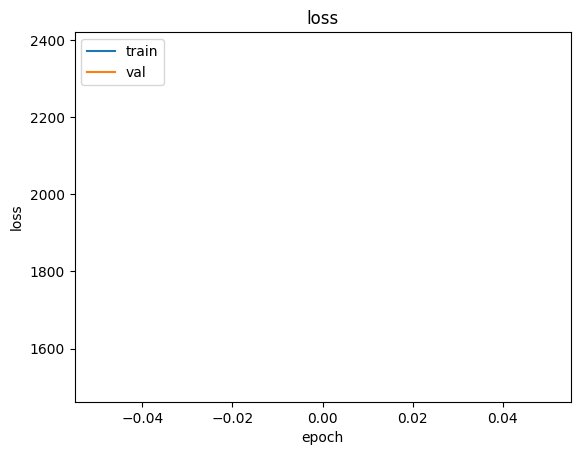

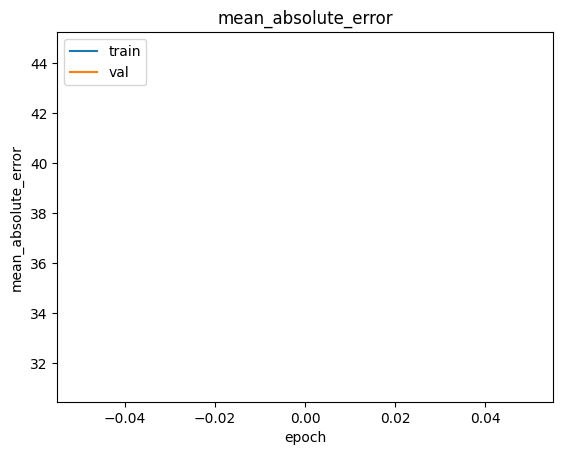

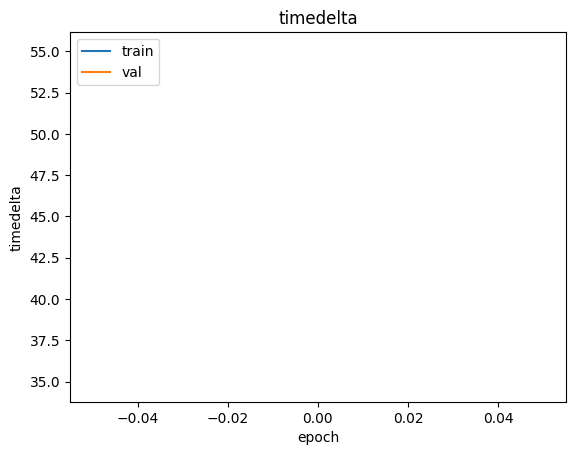

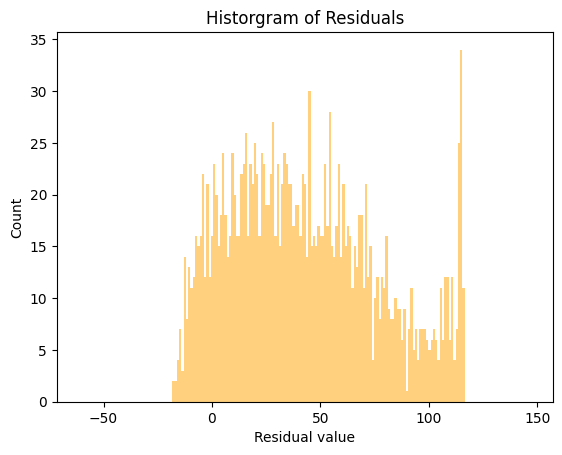

ValueError: too many values to unpack (expected 2)

In [28]:
report = RetentionTimeReport("reports", history)
report.generate_report(irts, prediction)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).